In [1]:
%load_ext nb_black
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


pd.set_option("max_colwidth", 80)

<IPython.core.display.Javascript object>

In [2]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd().parent / "data" / "final" / "public"
train_metadata = pd.read_csv(DATA_PATH / "training_set_features.csv")
train_labels = pd.read_csv(DATA_PATH / "training_set_labels.csv")
train_labels.describe()

,wind_speed
count,70257.000000
mean,50.344008
std,26.795277
min,15.000000
25%,30.000000
50%,43.000000
75%,62.000000
max,185.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Pillow:  L (366, 366)


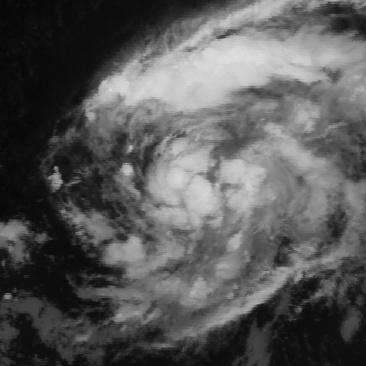

<IPython.core.display.Javascript object>

In [20]:
# Merge train_metadata with train_labels on the image_id field
full_metadata = train_metadata.merge(train_labels, on="image_id")
# Path style access for pandas
import pandas_path
from IPython.display import Image
from PIL import Image as pil_image

full_metadata["file_name"] = (
    DATA_PATH / "train" / full_metadata.image_id.path.with_suffix(".jpg")
)
examples = [
    pil_image.open(full_metadata.iloc[i]["file_name"]) for i in range(5)
]
print('Pillow: ', examples[1].mode, examples[1].size)
Image(str(full_metadata.iloc[1]["file_name"]))   

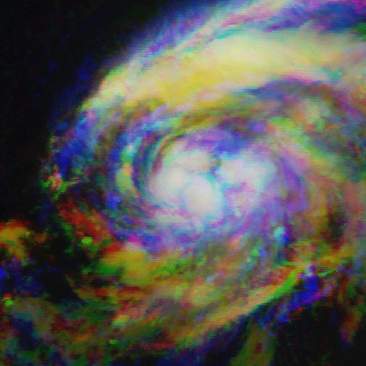

<IPython.core.display.Javascript object>

In [22]:
pil_image.merge('RGB', (examples[1],examples[2],examples[3]))

In [312]:
# Add a temporary column for number of images per storm
images_per_storm = full_metadata.groupby("storm_id").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="storm_id")
# Each storm is sorted by relative time
# Identify the final 20% of images per storm
#full_metadata["pct_of_storm"] = (
#    full_metadata.groupby("storm_id").cumcount() / full_metadata.images_per_storm
#)
full_metadata["pct_of_storm"] = (
    np.random.random_sample(max(full_metadata.shape))
)
full_metadata.head()

,image_id,storm_id,relative_time,ocean,wind_speed,file_name,images_per_storm,pct_of_storm
0,abs_000,abs,0,2,43,C:\Users\micha\data\final\public\train\abs_000.jpg,57,0.911133
1,abs_001,abs,1800,2,44,C:\Users\micha\data\final\public\train\abs_001.jpg,57,0.278917
2,abs_002,abs,5400,2,45,C:\Users\micha\data\final\public\train\abs_002.jpg,57,0.988286
3,abs_003,abs,17999,2,52,C:\Users\micha\data\final\public\train\abs_003.jpg,57,0.338073
4,abs_004,abs,19799,2,53,C:\Users\micha\data\final\public\train\abs_004.jpg,57,0.083318


<IPython.core.display.Javascript object>

In [314]:
full_train = full_metadata[full_metadata.pct_of_storm < 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
full_val = full_metadata[full_metadata.pct_of_storm >= 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
train = full_train.sample(frac=0.8, replace=False)
val = full_val.sample(frac=0.8, replace=False)
train.shape

(44972, 6)

<IPython.core.display.Javascript object>

In [315]:
val.shape

(2808, 6)

<IPython.core.display.Javascript object>

In [316]:
# Separate features from labels
x_train = train.drop("wind_speed", axis=1)
y_train = train.wind_speed

x_val = val.drop("wind_speed", axis=1)
y_val = val.wind_speed

<IPython.core.display.Javascript object>

In [317]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

<IPython.core.display.Javascript object>

In [348]:
class DatasetWIND(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_train, y_train=None):
        self.data = x_train 
        self.label = y_train
        self.transform = transforms.Compose(
            [
                transforms.Resize((128,128)),
                transforms.ToTensor(),
                # All models expect the same normalization mean & std
                # https://pytorch.org/docs/stable/torchvision/models.html
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = pil_image.open(self.data.iloc[index]["file_name"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.iloc[index]["image_id"]
        if self.label is not None:
            label = self.label.iloc[index]
            sample = {"image_id": image_id, "image": image, "label": label}
        else:
            sample = {
                "image_id": image_id,
                "image": image
            }
        return sample

<IPython.core.display.Javascript object>

In [349]:
class RMSELoss(nn.Module):
    """Measures root mean square error."""

    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, true):
        return torch.sqrt(self.mse(pred, true))

<IPython.core.display.Javascript object>

In [350]:
import warnings

import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm
from torch import nn
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [351]:
class PretrainedWindModel(pl.LightningModule):
    def __init__(self, hparams):
        super(PretrainedWindModel, self).__init__()
        self.hparams = hparams
        self.learning_rate = self.hparams.get("lr", 2e-4)
        self.hidden_size = self.hparams.get("embedding_dim", 50)
        self.dropout = self.hparams.get("dropout", 0.1)
        self.max_epochs = self.hparams.get("max_epochs", 1)
        self.num_workers = self.hparams.get("num_workers", 0)
        self.batch_size = self.hparams.get("batch_size", 10)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.num_outputs = 1  # One prediction for regression

        # Where final model will be saved
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model-outputs")
        self.output_path.mkdir(exist_ok=True)

        # Where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "logs")
        self.log_path.mkdir(exist_ok=True)
        self.logger = pl.loggers.TensorBoardLogger(
            self.log_path, name="benchmark_model"
        )

        # Instantiate training and validation datasets
        self.train_dataset = DatasetWIND(self.x_train, self.y_train)
        self.val_dataset = DatasetWIND(self.x_val, self.y_val)
        self.model = self.prepare_model()

    def prepare_model(self):
        res_model = models.resnet152(pretrained=True)
        # Input size of 2048 for resnet152
        # https://pytorch.org/hub/pytorch_vision_resnet/
        res_model.fc = nn.Sequential(
            nn.Linear(2048, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.num_outputs),
        )
        
        return res_model

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to training mode
        loss = criterion(
            self.model.train().forward(x).squeeze(), y.type(torch.FloatTensor).cuda()
        )
        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to evaluation mode
        loss = criterion(
            self.model.eval().forward(x).squeeze(), y.type(torch.FloatTensor).cuda()
        )
        tensorboard_logs = {"val_loss": loss}
        return {"batch_val_loss": loss, "log": tensorboard_logs}

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack(tuple(output["loss"] for output in outputs)).mean()
        return {
            "avg_epoch_train_loss": avg_train_loss,
            "progress_bar": {"avg_epoch_train_loss": avg_train_loss},
            "log": {"avg_epoch_train_loss": avg_train_loss},
        }

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack(
            tuple(output["batch_val_loss"] for output in outputs)
        ).mean()
        return {
            "avg_epoch_val_loss": avg_val_loss,
            "progress_bar": {"avg_epoch_val_loss": avg_val_loss},
            "log": {"avg_epoch_val_loss": avg_val_loss},
        }

    ## Convenience Methods ##

    def fit(self):
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            default_root_dir=self.output_path,
            logger=self.logger,
            checkpoint_callback=pl.callbacks.ModelCheckpoint(
                filepath=self.output_path,
                monitor="avg_epoch_val_loss",
                mode="min",
                verbose=True,
                
            ),
            gradient_clip_val=self.hparams.get("gradient_clip_val", 1),
            num_sanity_val_steps=self.hparams.get("val_sanity_checks", 0),
            gpus=1,
        )
        self.trainer.fit(self)

    @torch.no_grad()
    def make_submission_frame(self, x_test):
        test_dataset = DatasetWIND(x_test)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        submission_frame = pd.DataFrame(index=x_test.image_id, columns=["wind_speed"])
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            x = batch["image"]
            preds = self.eval().forward(x)
            submission_frame.loc[batch["image_id"], "wind_speed"] = (
                preds.detach().numpy().squeeze()
            )
        submission_frame.wind_speed = submission_frame.wind_speed.astype(float)
        return submission_frame
    
    def make_temporal_frame(self, x):
        test_dataset = DatasetWIND(x)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        temporal_frame = pd.DataFrame(index=x.image_id, columns=["wind_speed"])
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            i = batch["image"]
            preds = self.eval().forward(i)
            
            temporal_frame.loc[batch["image_id"], "wind_speed"] = (
                preds.detach().numpy().squeeze()
            )
            
            
        temporal_frame.wind_speedt1 = temporal_frame.wind_speed.astype(float)
        return temporal_frame

<IPython.core.display.Javascript object>

In [352]:
hparams = {
    # Required hparams
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    # Optional hparams
    "lr": 2e-4,
    "embedding_dim": 100,
    "dropout": 0.5,
    "max_epochs": 10,
    "batch_size": 10,
    "num_workers": 0,
    "gradient_clip_val": 1,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "logs",
}

<IPython.core.display.Javascript object>

In [353]:
best_checkpoint = str(Path("model-outputs") / "epoch=8-step=40481.ckpt")
storm_model = PretrainedWindModel(hparams=hparams)
storm_model = PretrainedWindModel.load_from_checkpoint(best_checkpoint)
storm_model.fit()

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 58.3 M
---------------------------------
58.3 M    Trainable params
0         Non-trainable params
58.3 M    Total params
INFO:lightning:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 58.3 M
---------------------------------
58.3 M    Trainable params
0         Non-trainable params
58.3 M    Total params


Epoch 0, global step 4497: avg_epoch_val_loss reached 9.05707 (best 9.05707), saving model to "C:\Users\micha\data\model-outputs\epoch=0-step=4497.ckpt" as top 1
INFO:lightning:Epoch 0, global step 4497: avg_epoch_val_loss reached 9.05707 (best 9.05707), saving model to "C:\Users\micha\data\model-outputs\epoch=0-step=4497.ckpt" as top 1


Epoch 1, global step 8995: avg_epoch_val_loss reached 8.48090 (best 8.48090), saving model to "C:\Users\micha\data\model-outputs\epoch=1-step=8995.ckpt" as top 1
INFO:lightning:Epoch 1, global step 8995: avg_epoch_val_loss reached 8.48090 (best 8.48090), saving model to "C:\Users\micha\data\model-outputs\epoch=1-step=8995.ckpt" as top 1


Epoch 2, global step 13493: avg_epoch_val_loss reached 8.30719 (best 8.30719), saving model to "C:\Users\micha\data\model-outputs\epoch=2-step=13493.ckpt" as top 1
INFO:lightning:Epoch 2, global step 13493: avg_epoch_val_loss reached 8.30719 (best 8.30719), saving model to "C:\Users\micha\data\model-outputs\epoch=2-step=13493.ckpt" as top 1


Epoch 3, global step 17991: avg_epoch_val_loss reached 7.68818 (best 7.68818), saving model to "C:\Users\micha\data\model-outputs\epoch=3-step=17991.ckpt" as top 1
INFO:lightning:Epoch 3, global step 17991: avg_epoch_val_loss reached 7.68818 (best 7.68818), saving model to "C:\Users\micha\data\model-outputs\epoch=3-step=17991.ckpt" as top 1


Epoch 4, step 22489: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 4, step 22489: avg_epoch_val_loss was not in top 1


Epoch 5, global step 26987: avg_epoch_val_loss reached 6.93099 (best 6.93099), saving model to "C:\Users\micha\data\model-outputs\epoch=5-step=26987.ckpt" as top 1
INFO:lightning:Epoch 5, global step 26987: avg_epoch_val_loss reached 6.93099 (best 6.93099), saving model to "C:\Users\micha\data\model-outputs\epoch=5-step=26987.ckpt" as top 1


Epoch 6, global step 31485: avg_epoch_val_loss reached 6.84560 (best 6.84560), saving model to "C:\Users\micha\data\model-outputs\epoch=6-step=31485.ckpt" as top 1
INFO:lightning:Epoch 6, global step 31485: avg_epoch_val_loss reached 6.84560 (best 6.84560), saving model to "C:\Users\micha\data\model-outputs\epoch=6-step=31485.ckpt" as top 1


Epoch 7, step 35983: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 7, step 35983: avg_epoch_val_loss was not in top 1


Epoch 8, global step 40481: avg_epoch_val_loss reached 6.63055 (best 6.63055), saving model to "C:\Users\micha\data\model-outputs\epoch=8-step=40481-v0.ckpt" as top 1
INFO:lightning:Epoch 8, global step 40481: avg_epoch_val_loss reached 6.63055 (best 6.63055), saving model to "C:\Users\micha\data\model-outputs\epoch=8-step=40481-v0.ckpt" as top 1


Epoch 9, step 44979: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 9, step 44979: avg_epoch_val_loss was not in top 1


<IPython.core.display.Javascript object>

In [368]:
best_checkpoint = str(Path("model-outputs") / "epoch=8-step=40481-v0.ckpt")
submission_format = pd.read_csv(
    DATA_PATH / "submission_format.csv", index_col="image_id"
)
submission_format.head()

,wind_speed
image_id,
acd_123,0
acd_124,0
acd_125,0
acd_126,0
acd_127,0


<IPython.core.display.Javascript object>

In [369]:
example_model = PretrainedWindModel.load_from_checkpoint(best_checkpoint)

test_metadata = pd.read_csv(DATA_PATH / "test_set_features.csv")
test_metadata["file_name"] = (
    DATA_PATH / "test" / test_metadata.image_id.path.with_suffix(".jpg")
)

submission = example_model.make_submission_frame(test_metadata)

100%|████████████████████████████████████████████████████████████████████████████| 4438/4438 [1:14:54<00:00,  1.01s/it]


<IPython.core.display.Javascript object>

In [370]:
# Ensure submission indices match submission format
assert submission_format.index.equals(submission.index)

<IPython.core.display.Javascript object>

In [371]:
submission = submission.round().astype(int)
submission.head()

,wind_speed
image_id,
acd_123,27
acd_124,27
acd_125,26
acd_126,25
acd_127,26


<IPython.core.display.Javascript object>

In [372]:
submission.wind_speed.describe()

count    44377.000000
mean        44.657413
std         22.168180
min         16.000000
25%         28.000000
50%         39.000000
75%         55.000000
max        153.000000
Name: wind_speed, dtype: float64

<IPython.core.display.Javascript object>

In [373]:
submission.to_csv((DATA_PATH / "submission.csv"), index=True) 

<IPython.core.display.Javascript object>

In [374]:
best_checkpoint = str(Path("model-outputs") / "epoch=8-step=40481-v0.ckpt")
example_model = PretrainedWindModel.load_from_checkpoint(best_checkpoint)
mini_metadata = pd.read_csv(DATA_PATH / "test_set_features.csv")
mini_metadata["file_name"] = (
    DATA_PATH / "test" / mini_metadata.image_id.path.with_suffix(".jpg")
)

temporal = example_model.make_temporal_frame(mini_metadata)
temporal = temporal.merge( mini_metadata, 'left', left_index=True, right_on="image_id")
temporal = temporal.drop(columns=['ocean', 'file_name'])
temporal["relative_time"]= temporal["relative_time"]*1e-6
temporal.head()

100%|████████████████████████████████████████████████████████████████████████████| 4438/4438 [1:16:28<00:00,  1.03s/it]


,wind_speed,image_id,storm_id,relative_time
0,26.9946,acd_123,acd,0.304198
1,26.5679,acd_124,acd,0.305998
2,25.9769,acd_125,acd,0.307798
3,25.0869,acd_126,acd,0.309598
4,25.6782,acd_127,acd,0.313198


<IPython.core.display.Javascript object>

In [375]:
temporal_shift= temporal.shift(1)
temporal_shift.drop(columns=['image_id'])

,wind_speed,storm_id,relative_time
0,NaN,NaN,NaN
1,26.9946,acd,0.304198
2,26.5679,acd,0.305998
3,25.9769,acd,0.307798
4,25.0869,acd,0.309598
...,...,...,...
44372,19.2756,zza,0.374402
44373,19.1158,zza,0.378002
44374,19.8146,zza,0.379802
44375,21.8776,zza,0.381602


<IPython.core.display.Javascript object>

In [376]:
temporal = temporal.merge(temporal_shift, 'inner', suffixes = ["","2"], right_index = True, left_index = True)
temporal['wind_speed2']= temporal['wind_speed2'].mask( temporal['storm_id'] != temporal['storm_id2'], temporal['wind_speed'])
temporal['relative_time2']= temporal['relative_time2'].mask( temporal['storm_id'] != temporal['storm_id2'], -1)
temporal = temporal.drop(columns=['image_id2', 'storm_id2'])
temporal.head()

,wind_speed,image_id,storm_id,relative_time,wind_speed2,relative_time2
0,26.9946,acd_123,acd,0.304198,26.9946,-1.000000
1,26.5679,acd_124,acd,0.305998,26.9946,0.304198
2,25.9769,acd_125,acd,0.307798,26.5679,0.305998
3,25.0869,acd_126,acd,0.309598,25.9769,0.307798
4,25.6782,acd_127,acd,0.313198,25.0869,0.309598


<IPython.core.display.Javascript object>

In [377]:
temporal_shift= temporal_shift.shift(1)
temporal = temporal.merge(temporal_shift, 'inner', suffixes = ["","3"], right_index = True, left_index = True)
temporal['wind_speed3']= temporal['wind_speed3'].mask( temporal['storm_id'] != temporal['storm_id3'], temporal['wind_speed2'])
temporal['relative_time3']= temporal['relative_time3'].mask( temporal['storm_id'] != temporal['storm_id3'], -1)
temporal = temporal.drop(columns=['image_id3', 'storm_id3'])
temporal_shift= temporal_shift.shift(1)
temporal = temporal.merge(temporal_shift, 'inner', suffixes = ["","4"], right_index = True, left_index = True)
temporal['wind_speed4']= temporal['wind_speed4'].mask( temporal['storm_id'] != temporal['storm_id4'], temporal['wind_speed3'])
temporal['relative_time4']= temporal['relative_time4'].mask( temporal['storm_id'] != temporal['storm_id4'], -1)
temporal = temporal.drop(columns=['image_id4', 'storm_id4'])
temporal_shift= temporal_shift.shift(1)
temporal = temporal.merge(temporal_shift, 'inner', suffixes = ["","5"], right_index = True, left_index = True)
temporal['wind_speed5']= temporal['wind_speed5'].mask( temporal['storm_id'] != temporal['storm_id5'], temporal['wind_speed4'])
temporal['relative_time5']= temporal['relative_time5'].mask( temporal['storm_id'] != temporal['storm_id5'], -1)
temporal = temporal.drop(columns=['image_id5', 'storm_id5'])

<IPython.core.display.Javascript object>

In [378]:
temporal.head()
temporal.to_csv((DATA_PATH / "temporal_test_set_features.csv"), index=True) 

<IPython.core.display.Javascript object>

In [379]:
train_metadata = pd.read_csv(DATA_PATH / "temporal_training_set_features.csv")
train_labels = pd.read_csv(DATA_PATH / "training_set_labels.csv")
# Merge train_metadata with train_labels on the image_id field
full_metadata = train_metadata.merge(train_labels, on="image_id",suffixes = ["","_y"] )
full_metadata["file_name"] = (
    DATA_PATH / "train" / full_metadata.image_id.path.with_suffix(".jpg")
)
full_metadata.head()

,Unnamed: 0,wind_speed,image_id,storm_id,relative_time,wind_speed2,relative_time2,wind_speed3,relative_time3,wind_speed4,relative_time4,wind_speed5,relative_time5,wind_speed_y,file_name
0,0,49.467781,abs_000,abs,0.000000,49.467781,-1.000000,49.467781,-1.0000,49.467781,-1.0000,49.467781,-1.0,43,C:\Users\micha\data\final\public\train\abs_000.jpg
1,1,45.510166,abs_001,abs,0.001800,49.467781,0.000000,49.467781,-1.0000,49.467781,-1.0000,49.467781,-1.0,44,C:\Users\micha\data\final\public\train\abs_001.jpg
2,2,44.894958,abs_002,abs,0.005400,45.510166,0.001800,49.467781,0.0000,49.467781,-1.0000,49.467781,-1.0,45,C:\Users\micha\data\final\public\train\abs_002.jpg
3,3,52.786148,abs_003,abs,0.017999,44.894958,0.005400,45.510166,0.0018,49.467781,0.0000,49.467781,-1.0,52,C:\Users\micha\data\final\public\train\abs_003.jpg
4,4,52.481560,abs_004,abs,0.019799,52.786148,0.017999,44.894958,0.0054,45.510166,0.0018,49.467781,0.0,53,C:\Users\micha\data\final\public\train\abs_004.jpg


<IPython.core.display.Javascript object>

In [380]:
full_metadata["pct_of_storm"] = (
    np.random.random_sample(max(full_metadata.shape))
)
full_train = full_metadata[full_metadata.pct_of_storm < 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
full_val = full_metadata[full_metadata.pct_of_storm >= 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
train = full_train.sample(frac=0.8, replace=False)
val = full_val.sample(frac=0.8, replace=False)
train.shape

(56206, 15)

<IPython.core.display.Javascript object>

In [381]:
val.shape

(14051, 15)

<IPython.core.display.Javascript object>

In [382]:
# Separate features from labels
x_train = train.drop("wind_speed_y", axis=1)
y_train = train.wind_speed_y

x_val = val.drop("wind_speed_y", axis=1)
y_val = val.wind_speed_y

x_train.head()

,Unnamed: 0,wind_speed,image_id,storm_id,relative_time,wind_speed2,relative_time2,wind_speed3,relative_time3,wind_speed4,relative_time4,wind_speed5,relative_time5,file_name
62352,62352,40.665123,xmf_145,xmf,0.324000,41.449192,0.320399,38.113361,0.318601,36.550411,0.316800,36.167515,0.315000,C:\Users\micha\data\final\public\train\xmf_145.jpg
59051,59051,82.547401,woz_065,woz,0.140399,82.089279,0.138599,89.863052,0.135001,96.731667,0.133201,96.749443,0.131401,C:\Users\micha\data\final\public\train\woz_065.jpg
6385,6385,38.161369,csd_039,csd,0.113400,33.579544,0.111600,36.008694,0.109801,37.624386,0.107999,44.196930,0.100800,C:\Users\micha\data\final\public\train\csd_039.jpg
64584,64584,19.105335,yfj_188,yfj,0.406801,21.584972,0.405002,19.154114,0.403201,20.935871,0.401401,22.953949,0.399602,C:\Users\micha\data\final\public\train\yfj_188.jpg
60814,60814,130.032242,xgr_046,xgr,0.104402,125.910561,0.102602,127.272461,0.100802,129.327637,0.099002,126.593269,0.097202,C:\Users\micha\data\final\public\train\xgr_046.jpg


<IPython.core.display.Javascript object>

In [383]:
class DatasetTemporalWIND(Dataset):
    """Reads in temporal data and provides readout.
    """

    def __init__(self, x_train, y_train=None):
        self.data = x_train 
        self.label = y_train
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        image_id = self.data.iloc[index]["image_id"]
        wind_speed = self.data.iloc[index]["wind_speed"]
        relative_time = self.data.iloc[index]["relative_time"]
        wind_speed2 = self.data.iloc[index]["wind_speed2"]
        relative_time2 = self.data.iloc[index]["relative_time2"]
        wind_speed3 = self.data.iloc[index]["wind_speed3"]
        relative_time3 = self.data.iloc[index]["relative_time3"]
        wind_speed4 = self.data.iloc[index]["wind_speed4"]
        relative_time4 = self.data.iloc[index]["relative_time4"]
        wind_speed5 = self.data.iloc[index]["wind_speed5"]
        relative_time5 = self.data.iloc[index]["relative_time5"]
        
        speeds_and_times = np.reshape(np.array([wind_speed, relative_time,wind_speed2,relative_time2,wind_speed3,relative_time3,
                                           wind_speed4,relative_time4,wind_speed5,relative_time5], dtype = 'float32'), (1,1,-1))
        
        if self.label is not None:
            label = self.label.iloc[index]
            
            sample = {"speeds_and_times": speeds_and_times, 
                      "image_id": image_id, 
                      "label": label}
        else:
            sample = {"speeds_and_times": speeds_and_times ,
                      "image_id": image_id}
        return sample

<IPython.core.display.Javascript object>

In [384]:
from torch.nn import functional as F
class TemporalWindModel(pl.LightningModule):
    
    def __init__(self, hparams):
        super(TemporalWindModel, self).__init__()
        self.hparams = hparams
        self.learning_rate = self.hparams.get("lr", 2e-4)
        self.hidden_size = self.hparams.get("embedding_dim", 50)
        self.dropout = self.hparams.get("dropout", 0.1)
        self.max_epochs = self.hparams.get("max_epochs", 1)
        self.num_workers = self.hparams.get("num_workers", 0)
        self.batch_size = self.hparams.get("batch_size", 10)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        # Where final model will be saved
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model-outputs")
        self.output_path.mkdir(exist_ok=True)

        # Where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "logs")
        self.log_path.mkdir(exist_ok=True)
        self.logger = pl.loggers.TensorBoardLogger(
        self.log_path, name="temporal_model"
        )
        self.model = self.prepare_model()
        self.lr = 0.01
        self.loss = RMSELoss()
        self.train_dataset = DatasetTemporalWIND(self.x_train, self.y_train)
        self.val_dataset = DatasetTemporalWIND(self.x_val, self.y_val)

    def prepare_model(self):
        model = nn.Sequential(
            nn.ReLU(10),
            nn.Linear(10,128),
            nn.Dropout(self.dropout),
            nn.Linear(128,10),
            nn.Linear(10,1)
        )
        
        return model
    
    def forward(self, x):
        return self.model(x)   

    def training_step(self, batch, batch_idx):
        x = batch["speeds_and_times"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to training mode
        loss = criterion(
            self.model.train().forward(x).squeeze(), y.type(torch.FloatTensor).cuda()
        )
        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x = batch["speeds_and_times"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to evaluation mode
        loss = criterion(
            self.model.eval().forward(x).squeeze(), y.type(torch.FloatTensor).cuda()
        )
        tensorboard_logs = {"val_loss": loss}
        return {"batch_val_loss": loss, "log": tensorboard_logs}

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack(tuple(output["loss"] for output in outputs)).mean()
        return {
            "avg_epoch_train_loss": avg_train_loss,
            "progress_bar": {"avg_epoch_train_loss": avg_train_loss},
            "log": {"avg_epoch_train_loss": avg_train_loss},
        }

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack(
            tuple(output["batch_val_loss"] for output in outputs)
        ).mean()
        return {
            "avg_epoch_val_loss": avg_val_loss,
            "progress_bar": {"avg_epoch_val_loss": avg_val_loss},
            "log": {"avg_epoch_val_loss": avg_val_loss},
        }

    ## Convenience Methods ##

    def fit(self):
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            default_root_dir=self.output_path,
            logger=self.logger,
            checkpoint_callback=pl.callbacks.ModelCheckpoint(
                filepath=self.output_path,
                monitor="avg_epoch_val_loss",
                mode="min",
                verbose=True,
                
            ),
            gradient_clip_val=self.hparams.get("gradient_clip_val", 1),
            num_sanity_val_steps=self.hparams.get("val_sanity_checks", 0),
            gpus=1,
        )
        self.trainer.fit(self)
        
    @torch.no_grad()
    
    def make_temporal_submission_frame(self, x_test):
        test_dataset = DatasetTemporalWIND(x_test)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        submission_frame = pd.DataFrame(index=x_test.image_id, columns=["wind_speed"])
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            x = batch["speeds_and_times"]
            preds = self.eval().forward(x)
            submission_frame.loc[batch["image_id"], "wind_speed"] = (
                preds.detach().numpy().squeeze()
            )
        submission_frame.wind_speed = submission_frame.wind_speed.astype(float)
        return submission_frame


<IPython.core.display.Javascript object>

In [385]:
hparams = {
    # Required hparams
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    # Optional hparams
    "lr": 2e-4,
    "embedding_dim": 100,
    "dropout": 0.5,
    "max_epochs": 10,
    "batch_size": 10,
    "num_workers": 0,
    "gradient_clip_val": 1,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "logs",
}

<IPython.core.display.Javascript object>

In [386]:
x_train.head()


,Unnamed: 0,wind_speed,image_id,storm_id,relative_time,wind_speed2,relative_time2,wind_speed3,relative_time3,wind_speed4,relative_time4,wind_speed5,relative_time5,file_name
62352,62352,40.665123,xmf_145,xmf,0.324000,41.449192,0.320399,38.113361,0.318601,36.550411,0.316800,36.167515,0.315000,C:\Users\micha\data\final\public\train\xmf_145.jpg
59051,59051,82.547401,woz_065,woz,0.140399,82.089279,0.138599,89.863052,0.135001,96.731667,0.133201,96.749443,0.131401,C:\Users\micha\data\final\public\train\woz_065.jpg
6385,6385,38.161369,csd_039,csd,0.113400,33.579544,0.111600,36.008694,0.109801,37.624386,0.107999,44.196930,0.100800,C:\Users\micha\data\final\public\train\csd_039.jpg
64584,64584,19.105335,yfj_188,yfj,0.406801,21.584972,0.405002,19.154114,0.403201,20.935871,0.401401,22.953949,0.399602,C:\Users\micha\data\final\public\train\yfj_188.jpg
60814,60814,130.032242,xgr_046,xgr,0.104402,125.910561,0.102602,127.272461,0.100802,129.327637,0.099002,126.593269,0.097202,C:\Users\micha\data\final\public\train\xgr_046.jpg


<IPython.core.display.Javascript object>

In [387]:
model = TemporalWindModel(hparams=hparams)
#best_checkpoint = str(Path("model-outputs") / "epoch=4-step=28104.ckpt")
#model = TemporalWindModel.load_from_checkpoint(best_checkpoint)
model.fit()

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2.7 K 
1 | loss  | RMSELoss   | 0     
-------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
INFO:lightning:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2.7 K 
1 | loss  | RMSELoss   | 0     
-------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params


Epoch 0, global step 5620: avg_epoch_val_loss reached 5.00497 (best 5.00497), saving model to "C:\Users\micha\data\model-outputs\epoch=0-step=5620.ckpt" as top 1
INFO:lightning:Epoch 0, global step 5620: avg_epoch_val_loss reached 5.00497 (best 5.00497), saving model to "C:\Users\micha\data\model-outputs\epoch=0-step=5620.ckpt" as top 1


Epoch 1, global step 11241: avg_epoch_val_loss reached 4.98582 (best 4.98582), saving model to "C:\Users\micha\data\model-outputs\epoch=1-step=11241-v0.ckpt" as top 1
INFO:lightning:Epoch 1, global step 11241: avg_epoch_val_loss reached 4.98582 (best 4.98582), saving model to "C:\Users\micha\data\model-outputs\epoch=1-step=11241-v0.ckpt" as top 1


Epoch 2, global step 16862: avg_epoch_val_loss reached 4.97994 (best 4.97994), saving model to "C:\Users\micha\data\model-outputs\epoch=2-step=16862.ckpt" as top 1
INFO:lightning:Epoch 2, global step 16862: avg_epoch_val_loss reached 4.97994 (best 4.97994), saving model to "C:\Users\micha\data\model-outputs\epoch=2-step=16862.ckpt" as top 1


Epoch 3, step 22483: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 3, step 22483: avg_epoch_val_loss was not in top 1


Epoch 4, step 28104: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 4, step 28104: avg_epoch_val_loss was not in top 1


Epoch 5, step 33725: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 5, step 33725: avg_epoch_val_loss was not in top 1


Epoch 6, step 39346: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 6, step 39346: avg_epoch_val_loss was not in top 1


Epoch 7, step 44967: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 7, step 44967: avg_epoch_val_loss was not in top 1


Epoch 8, step 50588: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 8, step 50588: avg_epoch_val_loss was not in top 1


Epoch 9, step 56209: avg_epoch_val_loss was not in top 1
INFO:lightning:Epoch 9, step 56209: avg_epoch_val_loss was not in top 1


<IPython.core.display.Javascript object>

In [389]:
# Best checkpoint based on logs
best_checkpoint = str(Path("model-outputs") / "epoch=2-step=16862.ckpt")
example_model = TemporalWindModel.load_from_checkpoint(best_checkpoint)
test_metadata =  pd.read_csv(DATA_PATH / "temporal_test_set_features.csv")
submission = example_model.make_temporal_submission_frame(test_metadata)


100%|██████████████████████████████████████████████████████████████████████████████| 4438/4438 [00:53<00:00, 82.19it/s]


<IPython.core.display.Javascript object>

In [390]:
submission_format = pd.read_csv(
    DATA_PATH / "submission_format.csv", index_col="image_id"
)
# Ensure submission indices match submission format
assert submission_format.index.equals(submission.index)

submission = submission.round().astype(int)
submission.head()

,wind_speed
image_id,
acd_123,29
acd_124,29
acd_125,28
acd_126,28
acd_127,28


<IPython.core.display.Javascript object>

In [391]:
submission.wind_speed.describe()

count    44377.000000
mean        46.358316
std         21.987635
min         17.000000
25%         30.000000
50%         40.000000
75%         57.000000
max        153.000000
Name: wind_speed, dtype: float64

<IPython.core.display.Javascript object>

In [392]:
submission.to_csv((DATA_PATH / "temporalsubmission.csv"), index=True) 

<IPython.core.display.Javascript object>